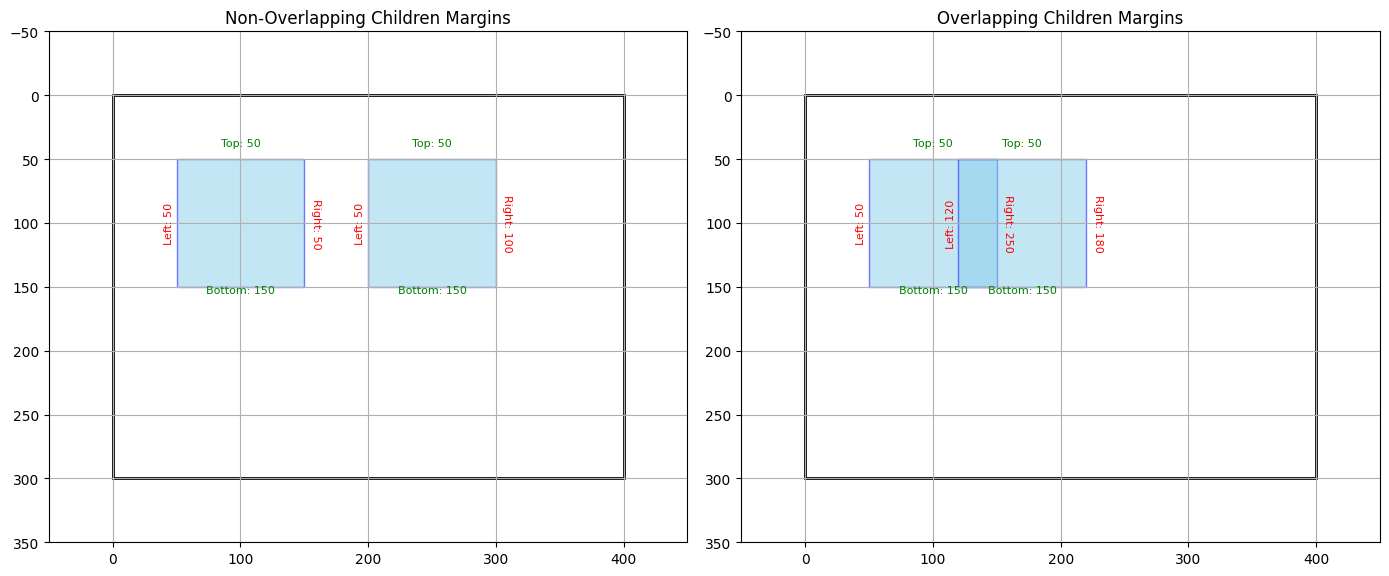

In [2]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.patches as patches # type: ignore

def compute_individual_margins(parent, children):
    """
    For each child, compute margins relative to the parent's boundaries.
    Also, for each side, check siblings (that overlap on the perpendicular axis)
    to compute the minimal gap (which may be negative if overlapping).

    Returns a list of dictionaries:
    [{'child': (x,y,w,h), 'left': L, 'right': R, 'top': T, 'bottom': B}, ...]
    """
    margins = []
    px, py, pw, ph = parent
    for i, child in enumerate(children):
        cx, cy, cw, ch = child

        # Start with margins from the parent's boundaries:
        left_margin = cx - px
        right_margin = (px + pw) - (cx + cw)
        top_margin = cy - py
        bottom_margin = (py + ph) - (cy + ch)

        # For horizontal margins, check siblings overlapping vertically.
        # Left: find siblings to the left (whose right edge is left of child's left)
        for j, other in enumerate(children):
            if i == j:
                continue
            ox, oy, ow, oh = other
            # Check for vertical overlap:
            if not (cy + ch < oy or cy > oy + oh):
                # If the other is to the left of the child:
                if ox + ow <= cx:
                    gap = cx - (ox + ow)
                    left_margin = min(left_margin, gap)
        # Right: find siblings to the right (whose left edge is right of child's right)
        for j, other in enumerate(children):
            if i == j:
                continue
            ox, oy, ow, oh = other
            if not (cy + ch < oy or cy > oy + oh):
                if ox >= cx + cw:
                    gap = ox - (cx + cw)
                    right_margin = min(right_margin, gap)

        # For vertical margins, check siblings overlapping horizontally.
        # Top: find siblings above (whose bottom is above child's top)
        for j, other in enumerate(children):
            if i == j:
                continue
            ox, oy, ow, oh = other
            if not (cx + cw < ox or cx > ox + ow):
                if oy + oh <= cy:
                    gap = cy - (oy + oh)
                    top_margin = min(top_margin, gap)
        # Bottom: find siblings below (whose top is below child's bottom)
        for j, other in enumerate(children):
            if i == j:
                continue
            ox, oy, ow, oh = other
            if not (cx + cw < ox or cx > ox + ow):
                if oy >= cy + ch:
                    gap = oy - (cy + ch)
                    bottom_margin = min(bottom_margin, gap)

        margins.append({
            'child': child,
            'left': left_margin,
            'right': right_margin,
            'top': top_margin,
            'bottom': bottom_margin
        })
    return margins

def plot_children_with_margins(ax, parent, children, margins, title):
    """
    Draw the parent rectangle, the children rectangles, and annotate
    each child with its computed margins.
    """
    px, py, pw, ph = parent
    # Draw parent rectangle (outline)
    parent_rect = patches.Rectangle((px, py), pw, ph, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(parent_rect)

    # Draw each child and annotate margins
    for i, child in enumerate(children):
        cx, cy, cw, ch = child
        rect = patches.Rectangle((cx, cy), cw, ch, linewidth=1, edgecolor='blue', facecolor='skyblue', alpha=0.5)
        ax.add_patch(rect)

        m = margins[i]
        # Annotate margins: left and right along the top edge, top and bottom along the left edge
        ax.text(cx + cw/2, cy - 10, f"Top: {m['top']}", fontsize=8, ha='center', color='green')
        ax.text(cx + cw/2, cy + ch + 5, f"Bottom: {m['bottom']}", fontsize=8, ha='center', color='green')
        ax.text(cx - 10, cy + ch/2, f"Left: {m['left']}", fontsize=8, va='center', color='red', rotation=90)
        ax.text(cx + cw + 5, cy + ch/2, f"Right: {m['right']}", fontsize=8, va='center', color='red', rotation=-90)

    ax.set_title(title)
    ax.set_xlim(px - 50, px + pw + 50)
    ax.set_ylim(py - 50, py + ph + 50)
    ax.set_aspect('equal')
    # Invert y-axis to mimic design tool coordinate systems (optional)
    ax.invert_yaxis()
    ax.grid(True)

# Define the parent rectangle: (x, y, width, height)
parent = (0, 0, 400, 300)

# Example 1: Non-overlapping children
children_non_overlap = [
    (50, 50, 100, 100),   # Child 1
    (200, 50, 100, 100)   # Child 2
]
margins_non_overlap = compute_individual_margins(parent, children_non_overlap)

# Example 2: Overlapping children
children_overlap = [
    (50, 50, 100, 100),   # Child 1
    (120, 50, 100, 100)   # Child 2 overlaps with Child 1
]
margins_overlap = compute_individual_margins(parent, children_overlap)

# Plotting both examples side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_children_with_margins(
    axes[0], parent, children_non_overlap, margins_non_overlap,
    "Non-Overlapping Children Margins"
)
plot_children_with_margins(
    axes[1], parent, children_overlap, margins_overlap,
    "Overlapping Children Margins"
)

plt.tight_layout()
plt.show()


Spacing and Padding Calculator Specification
============================================

Overview
--------

This document describes the logic and implementation for calculating individual margins for child nodes relative to a parent container, and then determining the parent's padding based on the children's positions. The system is designed to work with coordinate data from design tools (such as Figma), where each node is defined by its position (x, y) and dimensions (width, height).

Definitions
-----------

-   **Parent Rectangle:** Represented as either a tuple or dictionary with keys/values: `x`, `y`, `width`, `height`.
-   **Child Rectangle:** Represented as either a tuple `(x, y, width, height)` or dictionary with corresponding keys.
-   **Margin:** The gap between a child's edge and the parent's boundary or the adjacent sibling's edge (if present).
-   **Padding:** The distance from the parent's edges to the outer edges of all its children.

Margin Calculation (Per Child)
------------------------------

### Requirements

For each child node, calculate the margins:

-   **Left Margin:** Distance from the child's left edge to the parent's left edge or the nearest overlapping sibling's right edge.
-   **Right Margin:** Distance from the parent's right edge to the child's right edge or the nearest overlapping sibling's left edge.
-   **Top Margin:** Distance from the child's top edge to the parent's top edge or the nearest overlapping sibling's bottom edge.
-   **Bottom Margin:** Distance from the parent's bottom edge to the child's bottom edge or the nearest overlapping sibling's top edge.

If a computed margin is negative (i.e., when there is an overlap), the margin should be flagged accordingly.

### Calculation Logic

1.  **Basic Margin Calculation:**

    -   Left Margin: `child.x - parent.x`
    -   Right Margin: `(parent.x + parent.width) - (child.x + child.width)`
    -   Top Margin: `child.y - parent.y`
    -   Bottom Margin: `(parent.y + parent.height) - (child.y + child.height)`
2.  **Sibling Adjustment:**

    -   **Horizontal:**
        -   **Left:** For any sibling overlapping vertically and located to the left, calculate `gap = child.x - (sibling.x + sibling.width)` and choose the smallest gap.
        -   **Right:** For siblings overlapping vertically and located to the right, calculate `gap = sibling.x - (child.x + child.width)`.
    -   **Vertical:**
        -   **Top:** For siblings overlapping horizontally and located above, calculate `gap = child.y - (sibling.y + sibling.height)`.
        -   **Bottom:** For siblings overlapping horizontally and located below, calculate `gap = sibling.y - (child.y + child.height)`.
3.  **Overlap Flagging:**

    -   If any margin is negative after adjustment, flag that side as overlapping.

### Code Example (Margins)

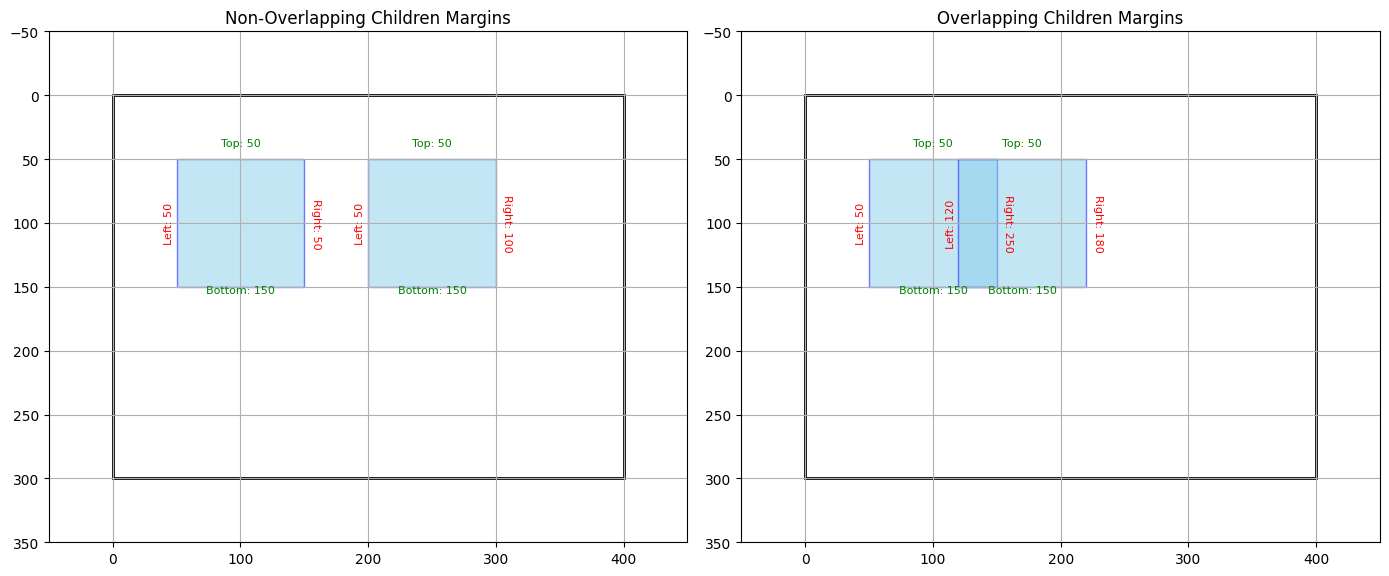

In [3]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.patches as patches # type: ignore

def compute_individual_margins(parent, children):
    """
    For each child, compute margins relative to the parent's boundaries.
    Also, for each side, check siblings (that overlap on the perpendicular axis)
    to compute the minimal gap. If the gap is negative, an overlap is flagged.

    Returns a list of dictionaries:
    [{
        'child': (x, y, w, h),
        'left': {'value': L, 'overlap': True/False},
        'right': {'value': R, 'overlap': True/False},
        'top': {'value': T, 'overlap': True/False},
        'bottom': {'value': B, 'overlap': True/False}
    }, ...]
    """
    results = []
    px, py, pw, ph = parent
    for i, child in enumerate(children):
        cx, cy, cw, ch = child

        # Start with basic margins relative to the parent's boundaries:
        left_margin = cx - px
        right_margin = (px + pw) - (cx + cw)
        top_margin = cy - py
        bottom_margin = (py + ph) - (cy + ch)

        # Flags for overlap (default False)
        left_overlap = False
        right_overlap = False
        top_overlap = False
        bottom_overlap = False

        # Horizontal adjustments (for left/right) using siblings overlapping vertically.
        for j, other in enumerate(children):
            if i == j:
                continue
            ox, oy, ow, oh = other
            # Check vertical overlap:
            if not (cy + ch <= oy or cy >= oy + oh):
                # Left side adjustment:
                if ox + ow <= cx:
                    gap = cx - (ox + ow)
                    if gap < left_margin:
                        left_margin = gap
                        left_overlap = gap < 0
                # Right side adjustment:
                if ox >= cx + cw:
                    gap = ox - (cx + cw)
                    if gap < right_margin:
                        right_margin = gap
                        right_overlap = gap < 0

        # Vertical adjustments (for top/bottom) using siblings overlapping horizontally.
        for j, other in enumerate(children):
            if i == j:
                continue
            ox, oy, ow, oh = other
            # Check horizontal overlap:
            if not (cx + cw <= ox or cx >= ox + ow):
                # Top side adjustment:
                if oy + oh <= cy:
                    gap = cy - (oy + oh)
                    if gap < top_margin:
                        top_margin = gap
                        top_overlap = gap < 0
                # Bottom side adjustment:
                if oy >= cy + ch:
                    gap = oy - (cy + ch)
                    if gap < bottom_margin:
                        bottom_margin = gap
                        bottom_overlap = gap < 0

        results.append({
            'child': child,
            'left': {'value': left_margin, 'overlap': left_overlap},
            'right': {'value': right_margin, 'overlap': right_overlap},
            'top': {'value': top_margin, 'overlap': top_overlap},
            'bottom': {'value': bottom_margin, 'overlap': bottom_overlap},
        })
    return results

def plot_children_with_margins(ax, parent, children, margins, title):
    """
    Draw the parent rectangle, the children rectangles, and annotate
    each child with its computed margins and overlap flags.
    """
    px, py, pw, ph = parent
    # Draw parent rectangle (outline)
    parent_rect = patches.Rectangle((px, py), pw, ph, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(parent_rect)

    # Draw each child and annotate margins
    for m in margins:
        child = m['child']
        cx, cy, cw, ch = child
        rect = patches.Rectangle((cx, cy), cw, ch, linewidth=1, edgecolor='blue', facecolor='skyblue', alpha=0.5)
        ax.add_patch(rect)

        # Prepare annotation strings with overlap flag if necessary
        top_str = f"Top: {m['top']['value']}{' (OL)' if m['top']['overlap'] else ''}"
        bottom_str = f"Bottom: {m['bottom']['value']}{' (OL)' if m['bottom']['overlap'] else ''}"
        left_str = f"Left: {m['left']['value']}{' (OL)' if m['left']['overlap'] else ''}"
        right_str = f"Right: {m['right']['value']}{' (OL)' if m['right']['overlap'] else ''}"

        # Annotate margins around the child
        ax.text(cx + cw/2, cy - 10, top_str, fontsize=8, ha='center', color='green')
        ax.text(cx + cw/2, cy + ch + 5, bottom_str, fontsize=8, ha='center', color='green')
        ax.text(cx - 10, cy + ch/2, left_str, fontsize=8, va='center', color='red', rotation=90)
        ax.text(cx + cw + 5, cy + ch/2, right_str, fontsize=8, va='center', color='red', rotation=-90)

    ax.set_title(title)
    ax.set_xlim(px - 50, px + pw + 50)
    ax.set_ylim(py - 50, py + ph + 50)
    ax.set_aspect('equal')
    # Invert y-axis to mimic design tool coordinate systems (optional)
    ax.invert_yaxis()
    ax.grid(True)

# Example usage for margin calculations:

# Define the parent rectangle: (x, y, width, height)
parent = (0, 0, 400, 300)

# Example 1: Non-overlapping children
children_non_overlap = [
    (50, 50, 100, 100),   # Child 1
    (200, 50, 100, 100)   # Child 2
]
margins_non_overlap = compute_individual_margins(parent, children_non_overlap)

# Example 2: Overlapping children
children_overlap = [
    (50, 50, 100, 100),   # Child 1
    (120, 50, 100, 100)   # Child 2 overlaps with Child 1
]
margins_overlap = compute_individual_margins(parent, children_overlap)

# Plotting the examples side by side
import matplotlib.pyplot as plt # type: ignore
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_children_with_margins(
    axes[0], parent, children_non_overlap, margins_non_overlap,
    "Non-Overlapping Children Margins"
)
plot_children_with_margins(
    axes[1], parent, children_overlap, margins_overlap,
    "Overlapping Children Margins"
)
plt.tight_layout()
plt.show()


Parent Padding Calculation
--------------------------

### Requirements

The parent's padding is computed based on the positions of all its children:

-   **Padding Left:** The smallest distance from any child's left edge to the parent's left edge.
-   **Padding Top:** The smallest distance from any child's top edge to the parent's top edge.
-   **Padding Right:** The smallest distance from the parent's right edge to any child's right edge.
-   **Padding Bottom:** The smallest distance from the parent's bottom edge to any child's bottom edge.

If any computed padding is negative, it is clamped to zero.

### Code Example (Padding)

In [5]:
def calculate_parent_padding(parent, children):
    """
    Calculate the parent's padding based on the positions of all its children.
    Padding is calculated for all four sides: left, top, right, and bottom.

    Input:
      parent: dictionary with keys 'x', 'y', 'width', 'height'
      children: list of dictionaries with keys 'x', 'y', 'width', 'height'

    Returns a dictionary with:
      'paddingLeft', 'paddingTop', 'paddingRight', 'paddingBottom'
    """
    if not children:
        return {
            'paddingLeft': 0,
            'paddingTop': 0,
            'paddingRight': 0,
            'paddingBottom': 0
        }

    # Calculate left and top padding
    padding_left = min(child['x'] - parent['x'] for child in children)
    padding_top = min(child['y'] - parent['y'] for child in children)

    # Calculate right and bottom padding
    padding_right = min((parent['x'] + parent['width']) - (child['x'] + child['width']) for child in children)
    padding_bottom = min((parent['y'] + parent['height']) - (child['y'] + child['height']) for child in children)

    return {
        'paddingLeft': max(padding_left, 0),  # Ensure padding is not negative
        'paddingTop': max(padding_top, 0),
        'paddingRight': max(padding_right, 0),
        'paddingBottom': max(padding_bottom, 0)
    }

# Example usage for padding calculation:
parent_dict = {'x': 0, 'y': 0, 'width': 400, 'height': 300}
children_dicts = [
    {'x': 50, 'y': 50, 'width': 100, 'height': 100},
    {'x': 200, 'y': 50, 'width': 100, 'height': 100}
]

padding = calculate_parent_padding(parent_dict, children_dicts)
print("Calculated Parent Padding:", padding)


Calculated Parent Padding: {'paddingLeft': 50, 'paddingTop': 50, 'paddingRight': 100, 'paddingBottom': 150}


Parent Padding Calculation
--------------------------

### Requirements

The parent's padding is computed based on the positions of all its children:

-   **Padding Left:** The smallest distance from any child's left edge to the parent's left edge.
-   **Padding Top:** The smallest distance from any child's top edge to the parent's top edge.
-   **Padding Right:** The smallest distance from the parent's right edge to any child's right edge.
-   **Padding Bottom:** The smallest distance from the parent's bottom edge to any child's bottom edge.

If any computed padding is negative, it is clamped to zero.

### Code Example (Padding)Summary
-------

-   **Margins:**\
    Each child's margins are computed based on its distance from the parent's boundaries and adjusted for overlapping siblings. Negative values indicate overlap and are flagged.

-   **Padding:**\
    The parent's padding is calculated as the minimal gap on each side between the parent's edges and the corresponding edges of its children. Negative gaps are clamped to zero.

This specification outlines the complete logic for spacing and padding calculations for a code generator, ensuring both margin adjustments for overlapping elements and proper parent padding updates.